- number of cores, set this number according to your computer

In [2]:
from helper import *
from stats import *
from product_info import *
from imp import reload  
import helper
import stats
reload(helper)
reload(stats)


<module 'stats' from 'C:\\Users\\dell\\stats.py'>

In [3]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM
## 16

16

- sample product, you can change to your specific product symbol

In [4]:
product_list = ["IF", "IH", "IC", "T", "TF"]

In [5]:
import dask
from dask import compute, delayed

- get the list of this form

In [30]:
all_dates = list(map(lambda x: x,os.listdir(DATA_PATH + product_list[0])))
n_days = len(all_dates)
n_days
## 1092

1092

- number of days

In [8]:
all_dates[:6]
# ['20151202.pkl',
#  '20151203.pkl',
#  '20151204.pkl',
#  '20151207.pkl',
#  '20151208.pkl',
#  '20151209.pkl']

['20151202.pkl',
 '20151203.pkl',
 '20151204.pkl',
 '20151207.pkl',
 '20151208.pkl',
 '20151209.pkl']

- some days may have error because of rolling contracts

- we randomly choose a day

In [11]:
data = load(DATA_PATH+product_list[0]+"/"+"20190828.pkl")

In [16]:
np.where(data["good"])

(array([28119, 28120, 28121, ..., 55599, 55600, 55601], dtype=int64),)

In [19]:
data["date"][0:28119]

0        20190827
1        20190827
2        20190827
3        20190827
4        20190827
           ...   
28114    20190827
28115    20190827
28116    20190827
28117    20190827
28118    20190827
Name: date, Length: 28119, dtype: object

In [23]:
data["date"][28119:55602]

28119    20190828
28120    20190828
28121    20190828
28122    20190828
28123    20190828
           ...   
55597    20190828
55598    20190828
55599    20190828
55600    20190828
55601    20190828
Name: date, Length: 27483, dtype: object

In [22]:
data["date"][55602:]

55602    20190829
55603    20190829
55604    20190829
55605    20190829
55606    20190829
           ...   
83061    20190829
83062    20190829
83063    20190829
83064    20190829
83065    20190829
Name: date, Length: 27464, dtype: object

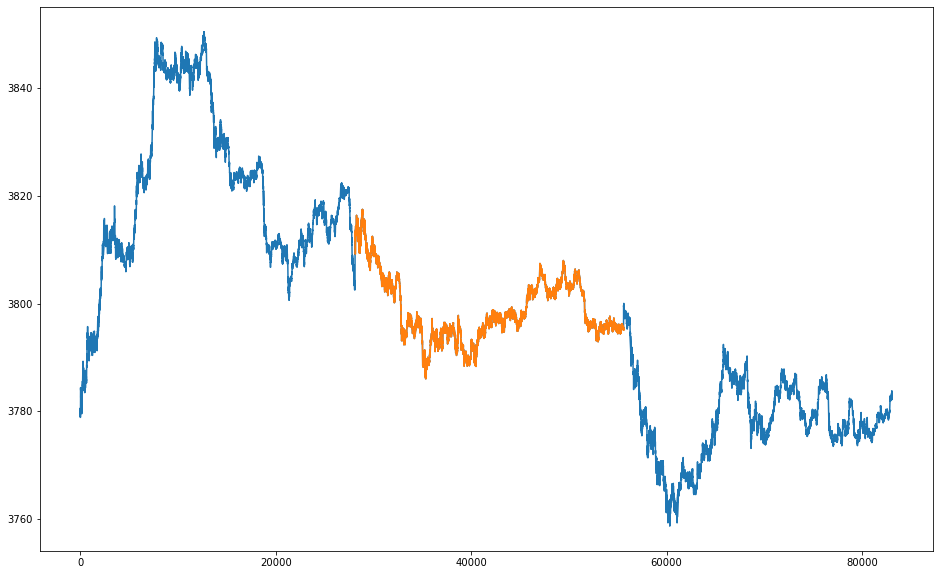

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(16, 10))
plt.plot(data.reset_index()["wpr"]);
plt.plot(data.reset_index()[data.reset_index()["good"]]["wpr"]);

In [31]:
data = load(DATA_PATH+product_list[0]+"/"+all_dates[0])


- plot all the data

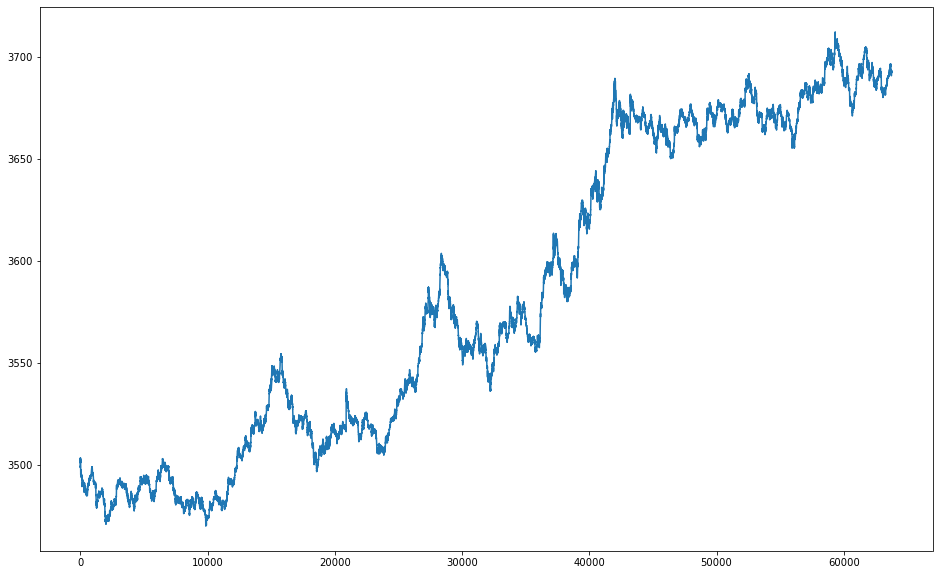

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1, figsize=(16, 10))
plt.plot(data["wpr"].values);

- Welcome to Quantitative and High Frequency Trading Training Program


- plot the data to be used in red

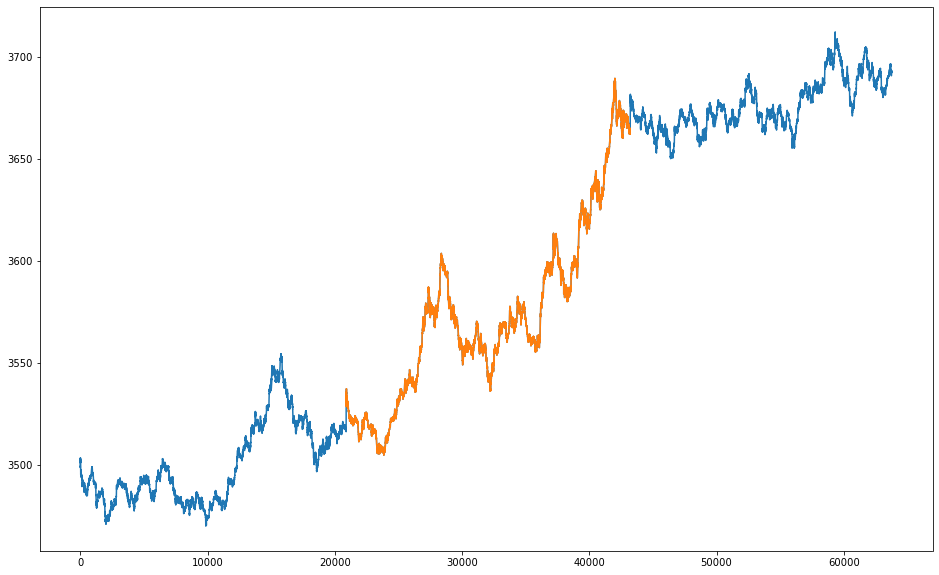

In [33]:
plt.figure(1, figsize=(16, 10))
plt.plot(data.reset_index()["wpr"]);
plt.plot(data.reset_index()[data.reset_index()["good"]]["wpr"]);

- number of usable points

In [34]:
sum(data["good"])
## 22322

22322

- total number of two days

In [35]:
len(data)
## 63776

63776

- so we only use the middle part of the data


- test the first predictive signal
- we can use look-back period of 4096 at first

In [36]:
period = 4096

- the first signal is the buy/sell imbalance signal


- create directory for all signals

- create directory for the product

In [37]:
import os
for product in product_list:
    os.makedirs(HEAD_PATH + "/tmp pkl/" + product, exist_ok=True)

- create directory for the signal

In [38]:
for product in product_list:
    os.makedirs(HEAD_PATH + "/tmp pkl/" + product + "/trade.imb." + str(period), exist_ok=True)

- now let's check the signal


- it's the buy/sell imbalance of one tick

- zero_divide is zero when denominator is zero
- we can see the definition of zero_divide in helper.py


- returns 0 if the numerator or denominator is 0

In [39]:
def zero_divide(x, y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = np.divide(x,y)
    if hasattr(y, "__len__"):
        res[y == 0] = 0
    elif y == 0:
        res = 0
        
    return res

In [40]:
class foctor_total_trade_imb_period(factor_template):
    factor_name = "total.trade.imb.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return vanish_thre(zero_divide(ewma(data["buy.trade"]+data["buy2.trade"]-data["sell.trade"]-data["sell2.trade"], period, adjust=True), 
                           ewma(data["qty"], period, adjust=True)),1).values

In [41]:
SAVE_PATH = "e:/intern"
x1 = foctor_total_trade_imb_period()
for product in product_list:
    create_signal_path(x1, product, SAVE_PATH);

e:/intern/tmp pkl/IF/total.trade.imb.1024
e:/intern/tmp pkl/IF/total.trade.imb.2048
e:/intern/tmp pkl/IF/total.trade.imb.4096
e:/intern/tmp pkl/IH/total.trade.imb.1024
e:/intern/tmp pkl/IH/total.trade.imb.2048
e:/intern/tmp pkl/IH/total.trade.imb.4096
e:/intern/tmp pkl/IC/total.trade.imb.1024
e:/intern/tmp pkl/IC/total.trade.imb.2048
e:/intern/tmp pkl/IC/total.trade.imb.4096
e:/intern/tmp pkl/T/total.trade.imb.1024
e:/intern/tmp pkl/T/total.trade.imb.2048
e:/intern/tmp pkl/T/total.trade.imb.4096
e:/intern/tmp pkl/TF/total.trade.imb.1024
e:/intern/tmp pkl/TF/total.trade.imb.2048
e:/intern/tmp pkl/TF/total.trade.imb.4096


In [42]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x1, product=product, HEAD_PATH=SAVE_PATH)
;
# Wall time: 5min 55s

Wall time: 5min 55s


''

- we can check the result

- we can see that they are the same
- so the signal calculation process is correct


- now calcualte all the value of this signal

In [43]:
import statsmodels.tsa.stattools as ts
import math

In [44]:
to_choose = np.where(np.mod(range(n_days),10)==0)
signal_name = "total.trade.imb.4096"
for product in product_list:
    all_signal = np.array([])
    for file in np.array(all_dates)[to_choose]:
        data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        S = S[data["good"]]
        all_signal = np.concatenate((all_signal, S), axis=0)
    sample_signal = all_signal[np.arange(1,len(all_signal)+1)% period==0]
    result = ts.adfuller(sample_signal, maxlag=int(pow(len(sample_signal)-1,(1/3))), regression='ct', autolag=None)
    print(product, "adf", result)
    result = ts.kpss(sample_signal, regression='c', lags=int(3*math.sqrt(len(sample_signal))/13))
    print(product, "kpss", result)
    
# IF adf (-7.918898151472552, 1.1003088564459632e-10, 8, 589, {'1%': -3.9742228888922906, '5%': -3.4179702581442277, '10%': -3.1314512365829814})
# IF kpss (0.1138845200494282, 0.1, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
# IH adf (-7.311533266706166, 2.7594956010087832e-09, 7, 478, {'1%': -3.97783518819259, '5%': -3.419714900319874, '10%': -3.132476588382923})
# IH kpss (0.31206764172536167, 0.1, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
# IC adf (-7.598684906058964, 6.039259186330334e-10, 8, 571, {'1%': -3.974712728207374, '5%': -3.4182069247551627, '10%': -3.131590354723473})
# IC kpss (0.37198088640135696, 0.08923237655113925, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
# T adf (-7.728163247147433, 3.035724362372074e-10, 7, 480, {'1%': -3.977755223479094, '5%': -3.419676295699508, '10%': -3.132453904622396})
# T kpss (0.11201081932632016, 0.1, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
# TF adf (-5.477987763813484, 2.5469875517658277e-05, 6, 273, {'1%': -3.9923195674201506, '5%': -3.426695522751254, '10%': -3.136574826282682})
# TF kpss (0.19141586665233778, 0.1, 3, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


IF adf (-7.918898151472552, 1.1003088564459632e-10, 8, 589, {'1%': -3.9742228888922906, '5%': -3.4179702581442277, '10%': -3.1314512365829814})
IF kpss (0.1138845200494282, 0.1, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


IH adf (-7.311533266706166, 2.7594956010087832e-09, 7, 478, {'1%': -3.97783518819259, '5%': -3.419714900319874, '10%': -3.132476588382923})
IH kpss (0.31206764172536167, 0.1, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


IC adf (-7.598684906058964, 6.039259186330334e-10, 8, 571, {'1%': -3.974712728207374, '5%': -3.4182069247551627, '10%': -3.131590354723473})
IC kpss (0.37198088640135696, 0.08923237655113925, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
T adf (-7.728163247147433, 3.035724362372074e-10, 7, 480, {'1%': -3.977755223479094, '5%': -3.419676295699508, '10%': -3.132453904622396})
T kpss (0.11201081932632016, 0.1, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


TF adf (-5.477987763813484, 2.5469875517658277e-05, 6, 273, {'1%': -3.9923195674201506, '5%': -3.426695522751254, '10%': -3.136574826282682})
TF kpss (0.19141586665233778, 0.1, 3, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


- for adf, if p-valus(the second one) is small, then it's stationary;
- for kpss, if p-value is large, then it's stationary;
- so for trade.imb.4096, all of them are stationary
- now we calcualte another signal which measures the range ranther than direciton

In [45]:
class foctor_trade_imb_period(factor_template):
    factor_name = "trade.imb.period"
    
    params = OrderedDict([
        ("period", np.power(2, range(10,13)))
    ])
    
    def formula(self, data, period):
        return ewma(zero_divide(data["buy.trade"] - data["sell.trade"], data["buy.trade"] + data["sell.trade"]), period, adjust=True).values

In [46]:
x4 = foctor_trade_imb_period()
for product in product_list:
    create_signal_path(x4, product, SAVE_PATH);

e:/intern/tmp pkl/IF/trade.imb.1024
e:/intern/tmp pkl/IF/trade.imb.2048
e:/intern/tmp pkl/IF/trade.imb.4096
e:/intern/tmp pkl/IH/trade.imb.1024
e:/intern/tmp pkl/IH/trade.imb.2048
e:/intern/tmp pkl/IH/trade.imb.4096
e:/intern/tmp pkl/IC/trade.imb.1024
e:/intern/tmp pkl/IC/trade.imb.2048
e:/intern/tmp pkl/IC/trade.imb.4096
e:/intern/tmp pkl/T/trade.imb.1024
e:/intern/tmp pkl/T/trade.imb.2048
e:/intern/tmp pkl/T/trade.imb.4096
e:/intern/tmp pkl/TF/trade.imb.1024
e:/intern/tmp pkl/TF/trade.imb.2048
e:/intern/tmp pkl/TF/trade.imb.4096


In [47]:
%%time
for product in product_list:
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, build_composite_signal,signal_list=x4, product=product, HEAD_PATH=SAVE_PATH)
# Wall time: 4min 34s

Wall time: 4min 34s


In [53]:
period = 4096
to_choose = np.where(np.mod(range(n_days),10)==0)
signal_name = "trade.imb.4096"
for product in product_list:
    all_signal = np.array([])
    for file in np.array(all_dates)[to_choose]:
        data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        S = S[data["good"]]
        all_signal = np.concatenate((all_signal, S), axis=0)
    sample_signal = all_signal[np.arange(1,len(all_signal)+1)% period==0]
    result = ts.adfuller(sample_signal, maxlag=int(pow(len(sample_signal)-1,(1/3))), regression='ct', autolag=None)
    print(product, "adf", result)
    result = ts.kpss(sample_signal, regression='c', lags=int(3*math.sqrt(len(sample_signal))/13))
    print(product, "kpss", result)

# IF adf (-5.503621136129018, 2.2668672522857516e-05, 8, 589, {'1%': -3.9742228888922906, '5%': -3.4179702581442277, '10%': -3.1314512365829814})
# IF kpss (5.03393531356536, 0.01, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
# IH adf (-6.273600628925358, 5.741410435645366e-07, 7, 478, {'1%': -3.97783518819259, '5%': -3.419714900319874, '10%': -3.132476588382923})
# IH kpss (3.2647413679694544, 0.01, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
# IC adf (-5.190038641209456, 9.145247329520116e-05, 8, 571, {'1%': -3.974712728207374, '5%': -3.4182069247551627, '10%': -3.131590354723473})
# IC kpss (5.142219937573656, 0.01, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
# T adf (-8.47099578446152, 5.849418074639007e-12, 7, 480, {'1%': -3.977755223479094, '5%': -3.419676295699508, '10%': -3.132453904622396})
# T kpss (0.14337965097125144, 0.1, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
# TF adf (-5.094080731995692, 0.0001381947150365656, 6, 273, {'1%': -3.9923195674201506, '5%': -3.426695522751254, '10%': -3.136574826282682})
# TF kpss (0.13276500632398558, 0.1, 3, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


IF adf (-5.503621136129018, 2.2668672522857516e-05, 8, 589, {'1%': -3.9742228888922906, '5%': -3.4179702581442277, '10%': -3.1314512365829814})
IF kpss (5.03393531356536, 0.01, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


IH adf (-6.273600628925358, 5.741410435645366e-07, 7, 478, {'1%': -3.97783518819259, '5%': -3.419714900319874, '10%': -3.132476588382923})
IH kpss (3.2647413679694544, 0.01, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
IC adf (-5.190038641209456, 9.145247329520116e-05, 8, 571, {'1%': -3.974712728207374, '5%': -3.4182069247551627, '10%': -3.131590354723473})
IC kpss (5.142219937573656, 0.01, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


T adf (-8.47099578446152, 5.849418074639007e-12, 7, 480, {'1%': -3.977755223479094, '5%': -3.419676295699508, '10%': -3.132453904622396})
T kpss (0.14337965097125144, 0.1, 5, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


TF adf (-5.094080731995692, 0.0001381947150365656, 6, 273, {'1%': -3.9923195674201506, '5%': -3.426695522751254, '10%': -3.136574826282682})
TF kpss (0.13276500632398558, 0.1, 3, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})


d:\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [54]:
def get_atr(file, product, period_list, spread, HEAD_PATH):
    data = load(file)
    for period in period_list:
        S = (data["max."+str(period)]-data["min."+str(period)])/spread
        save(S, HEAD_PATH+"/tmp pkl/"+product+"/atr."+str(period)+"/" + file[-12:])


In [55]:
for product in product_list:
    for period in [1024,2048,4096]:
        os.makedirs(SAVE_PATH + "/tmp pkl/" + product+"/atr."+str(period), exist_ok=True)

In [56]:
%%time
for product in product_list:
    spread = product_info[product]["spread"]
    file_list = list(map(lambda x: DATA_PATH+product+"/"+x, os.listdir(DATA_PATH + product)))
    parLapply(CORE_NUM, file_list, get_atr, product=product,period_list=np.power(2, range(10,13)), spread=spread, HEAD_PATH=SAVE_PATH) 

# Wall time: 2min 7s

Wall time: 2min 7s


- It measures how many bid/ask spreads of range in the previous period 
- In this case, we can measure volatility of each product in similar criteron
- because slippage is the largest cost for intraday trading

- Then we can modify our backtest program to include a trend signal and a range signal

In [57]:
from collections import OrderedDict
def get_signal_pnl(file, product, signal_name, thre_mat, reverse=1, tranct=1.1e-4, max_spread=0.61, tranct_ratio=True, 
                   HEAD_PATH="d:/intern", SAVE_PATH="e:/intern", atr_filter=0):
    ## load data
    data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
    S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
    pred = S*reverse
    pred = pred[data["good"]]
    atr = load(SAVE_PATH+"/tmp pkl/"+product+"/"+"atr.4096"+"/"+file)
    atr = atr[data["good"]].reset_index(drop=True)
    data = data[data["good"]].reset_index(drop=True)
    #n_bar = len(data)
    
    ## load signal
    
    ## we don't know the signal is positive correlated or negative correlated  
    #n_thre = len(thre_mat)
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.pnl", 0), ("pnl", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)
    count = 0;
    cur_spread = data["ask"]-data["bid"]
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        signal[atr<atr_filter]=0
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 1
        position_pos[(pred< -scratch) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos = pd.Series(data=0, index=data.index)
        notional_position_pos[position_pos==1] = 1
        notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos[(notional_position_pos==1)] = 1/data["next.ask"][(notional_position_pos==1)]
        notional_position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = -1
        position_neg[(pred> scratch) & (data["next.ask"]>0) & (cur_spread<max_spread)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg = pd.Series(data=0, index=data.index)
        notional_position_neg[position_neg==-1] = -1
        notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg[(notional_position_neg==-1)] = -1/data["next.bid"][(notional_position_neg==-1)]
        notional_position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position = notional_position_pos+notional_position_neg
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-2:] = 0
        notional_position.iloc[0] = 0
        notional_position.iloc[-2:] = 0
        change_pos = position - position.shift(1)
        notional_change_pos = notional_position-notional_position.shift(1)
        change_pos.iloc[0] = 0
        notional_change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        if (tranct_ratio):
            change_base[change_buy] = data["next.ask"][change_buy]*(1+tranct)
            change_base[change_sell] = data["next.bid"][change_sell]*(1-tranct)
        else:
            change_base[change_buy] = data["next.ask"][change_buy]+tranct
            change_base[change_sell] = data["next.bid"][change_sell]-tranct
        final_pnl = -sum(change_base*change_pos)
        ret = -sum(change_base*notional_change_pos)
        num = sum((position!=0) & (change_pos!=0))
        if num == 0:
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (0,0,0,0,0)
            return result
        else:
            avg_pnl = np.divide(final_pnl, num)
            avg_ret = np.divide(ret,num)
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (num, avg_pnl, final_pnl, avg_ret,ret)
    return result

- First we want to know the range of signal

In [58]:
to_choose = (np.arange(n_days)+1) % 10 == 0
## chooose one day out of 10 days
signal_name = "total.trade.imb.4096"
all_product_signal = dict([])
for product in product_list:
    all_signal = np.array([])
    for file in np.array(all_dates)[to_choose]:
        data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        S = S[data["good"]]
        all_signal = np.concatenate((all_signal, S), axis=0)
    all_product_signal[product] = all_signal

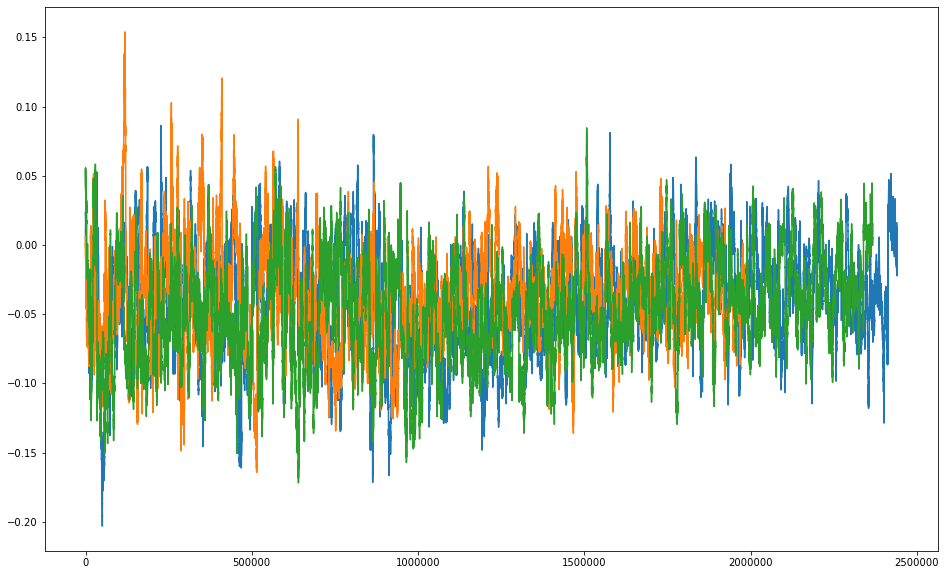

In [59]:
for product in ["IF","IH","IC"]:
    plt.figure(1, figsize=(16, 10))
    plt.plot(all_product_signal[product]);

- we can plot the range together in one graph

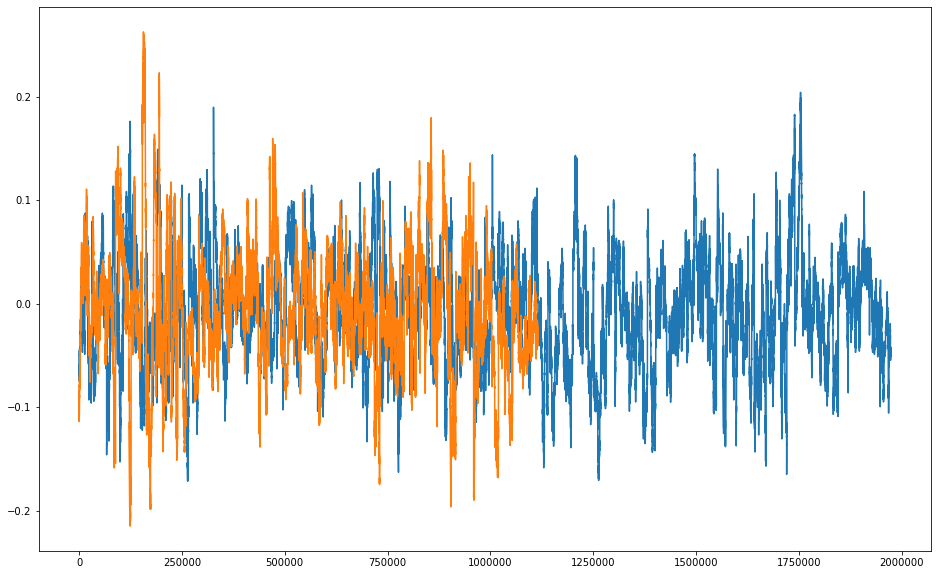

In [60]:
for product in ["T","TF"]:
    plt.figure(1, figsize=(16, 10))
    plt.plot(all_product_signal[product]);

In [61]:
to_choose = (np.arange(n_days)+1) % 10 == 0
## chooose one day out of 10 days
signal_name = "trade.imb.4096"
all_product_signal = dict([])
for product in product_list:
    all_signal = np.array([])
    for file in np.array(all_dates)[to_choose]:
        data = load(HEAD_PATH+"/pkl tick/"+product+"/"+file)
        S = load(SAVE_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file)
        S = S[data["good"]]
        all_signal = np.concatenate((all_signal, S), axis=0)
    all_product_signal[product] = all_signal

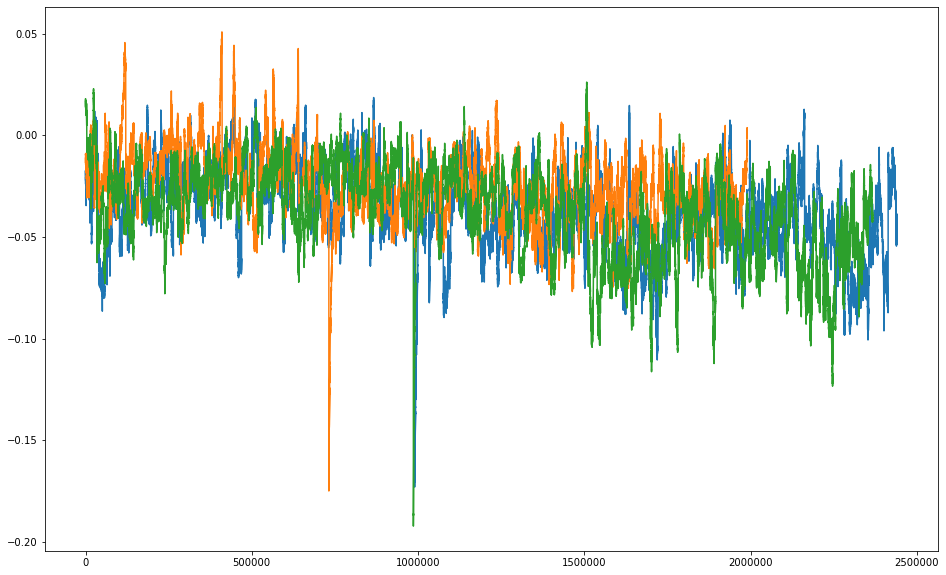

In [62]:
for product in product_list[0:3]:
    plt.figure(1, figsize=(16, 10))
    plt.plot(all_product_signal[product]);

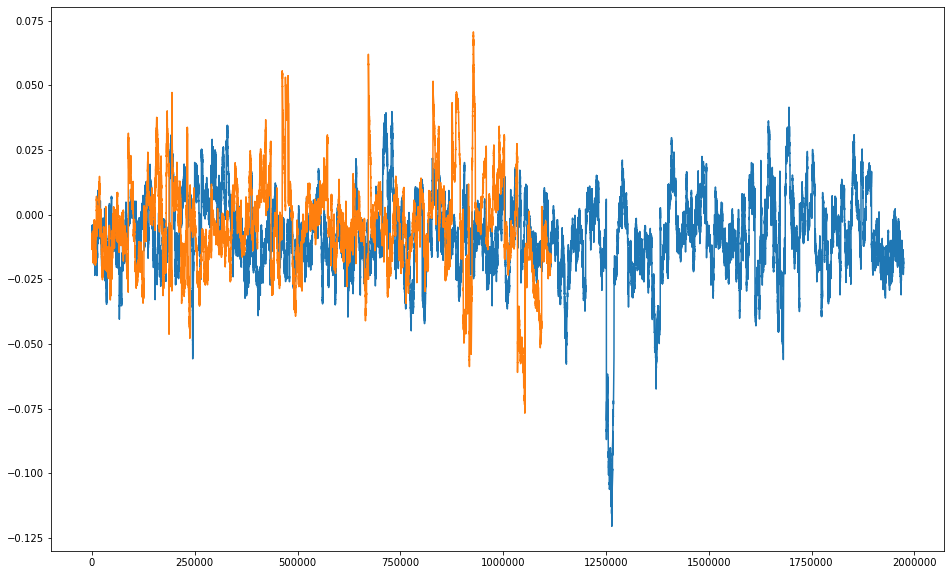

In [63]:
for product in product_list[3:5]:
    plt.figure(1, figsize=(16, 10))
    plt.plot(all_product_signal[product]);

- then at the quantile values

In [64]:
from collections import OrderedDict
def get_hft_summary(result, thre_mat, n):
    all_result = pd.DataFrame(data={"daily.result": result})
    daily_num = all_result['daily.result'].apply(lambda x: x["num"])
    daily_pnl = all_result['daily.result'].apply(lambda x: x["pnl"])
    daily_ret = all_result['daily.result'].apply(lambda x: x["ret"])
    total_num = daily_num.sum()
    if len(total_num) != len(thre_mat):
        raise selfException("Mismatch!")
    total_pnl = daily_pnl.sum()
    total_ret = daily_ret.sum()
    avg_pnl = zero_divide(total_pnl, total_num)
    avg_ret = zero_divide(total_ret, total_num)
    total_sharp = sharpe(daily_pnl)
    total_drawdown = drawdown(daily_pnl)
    total_max_drawdown = max_drawdown(daily_pnl)
    sharpe_ret = sharpe(daily_ret)
    drawdown_ret = drawdown(daily_ret)
    max_drawdown_ret = max_drawdown(daily_ret)
    final_result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"]), ("close", thre_mat["close"]), ("num", total_num),
                                                 ("avg.pnl", avg_pnl), ("total.pnl", total_pnl), ("sharpe", total_sharp), 
                                                 ("drawdown", total_drawdown), ("max.drawdown", total_max_drawdown), 
                                                  ("avg.ret", avg_ret), ("total.ret",total_ret), ("sharpe.ret", sharpe_ret),
                                                  ("drawdown.ret", drawdown_ret), ("max.drawdown.ret", max_drawdown_ret),
                                                 ("mar", total_pnl/total_max_drawdown), ("mar.ret", total_ret/max_drawdown_ret)]), 
                                index=thre_mat.index)
    return OrderedDict([("final.result", final_result), ("daily.num", daily_num), ("daily.pnl", daily_pnl), ("daily.ret", daily_ret)])


In [66]:
%%time
signal_name = "total.trade.imb.4096"
all_trade_stat = dict([])
from collections import OrderedDict
import itertools
open_list = np.arange(0.11, 0.15, 0.002)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
index_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
from collections import OrderedDict
import itertools
open_list = np.arange(0.1, 0.2, 0.005)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
treasury_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    if product in ["IF","IH","IC"]:
        thre_mat = index_thre_mat
    else:
        thre_mat = treasury_thre_mat
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat

# Wall time: 11min 23s

Wall time: 11min 23s


In [67]:
save(all_trade_stat, HEAD_PATH+"/"+"finance_trade_stat_total_trade_imb_4096.pkl")

In [68]:
%%time
signal_name = "trade.imb.4096"
all_trade_stat = dict([])
from collections import OrderedDict
import itertools
open_list = np.arange(0.03, 0.05, 0.001)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
index_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
open_list = np.arange(0.03, 0.07, 0.002)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
treasury_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    if product in ["IF","IH","IC"]:
        thre_mat = index_thre_mat
    else:
        thre_mat = treasury_thre_mat
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20)
        result = compute([delayed(f_par)(file) for file in all_dates])[0]
    trade_stat = get_hft_summary(result, thre_mat, n_days)
    all_trade_stat[product] = trade_stat

# Wall time: 34min 24s


Wall time: 34min 24s


In [69]:
save(all_trade_stat, HEAD_PATH+"/"+"finance_trade_stat_trade_imb_4096.pkl")

- it seems the signal value leans to negative

- for example we care about the average pnl

In [70]:
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])

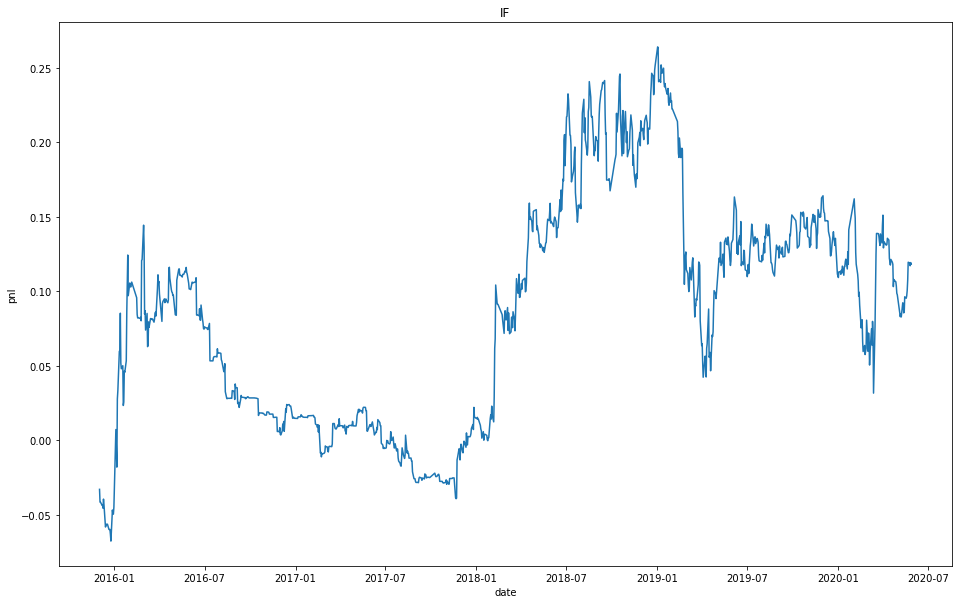

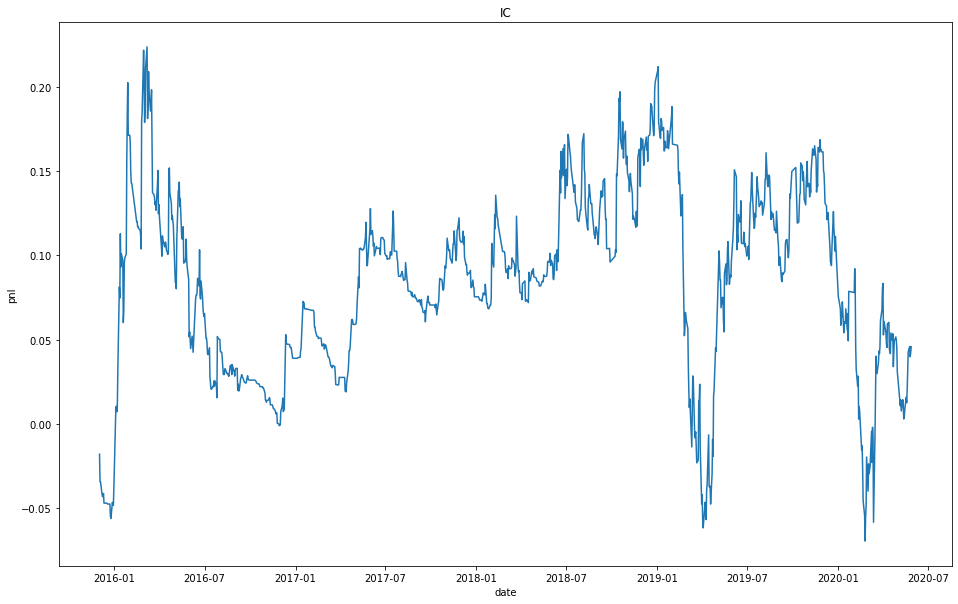

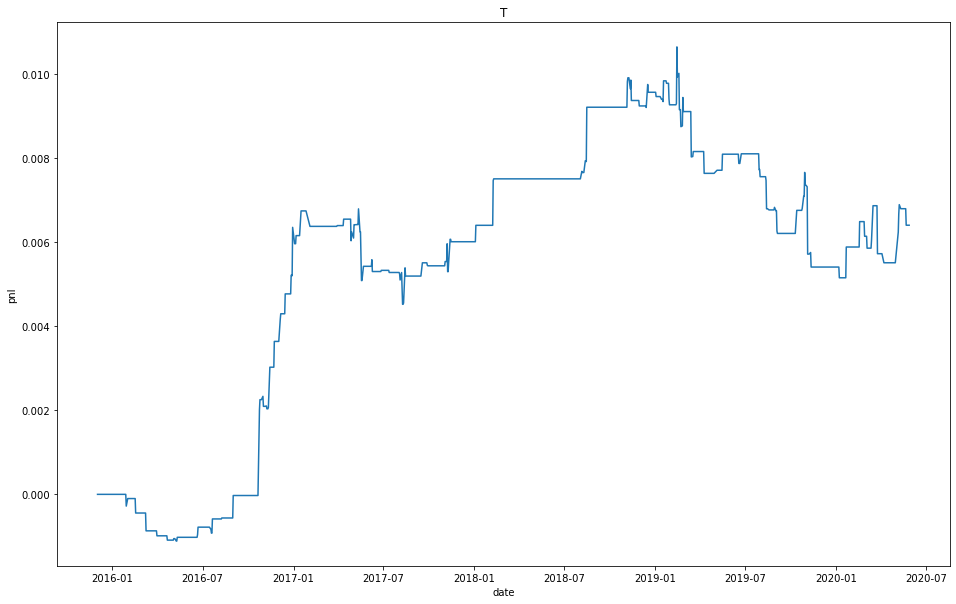

In [120]:
all_trade_stat = load(HEAD_PATH+"/"+"finance_trade_stat_trade_imb_4096.pkl")
all_pnl = np.zeros([n_days, len(product_list)])
i = 0
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
    if sum(good_strat)==0:
        continue;
    good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    all_pnl[:,i] = good_pnl
    i = i+1
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates, good_pnl.cumsum());

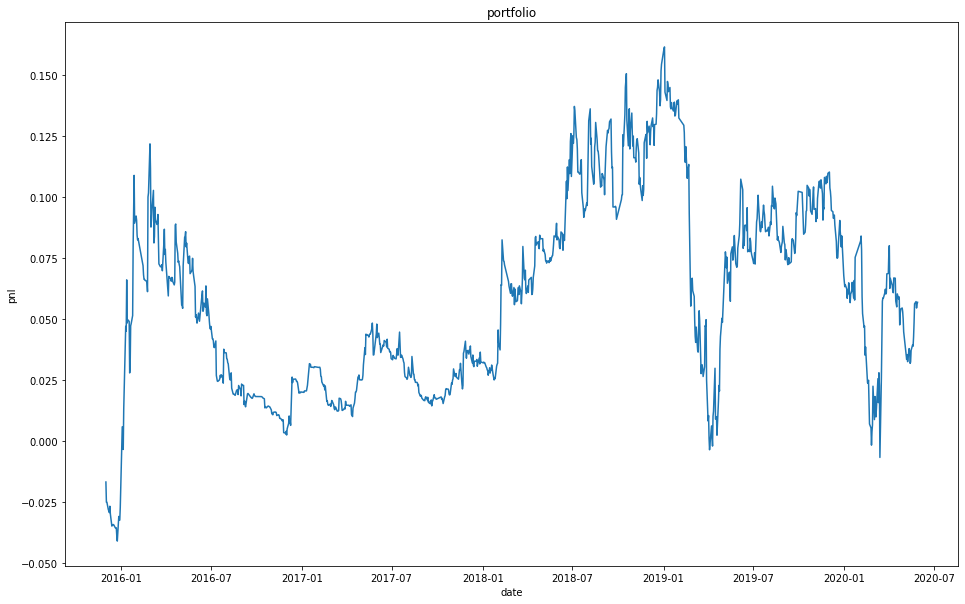

In [121]:
all_portfolio = np.array(np.mean(all_pnl[:,:i], axis=1))
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());

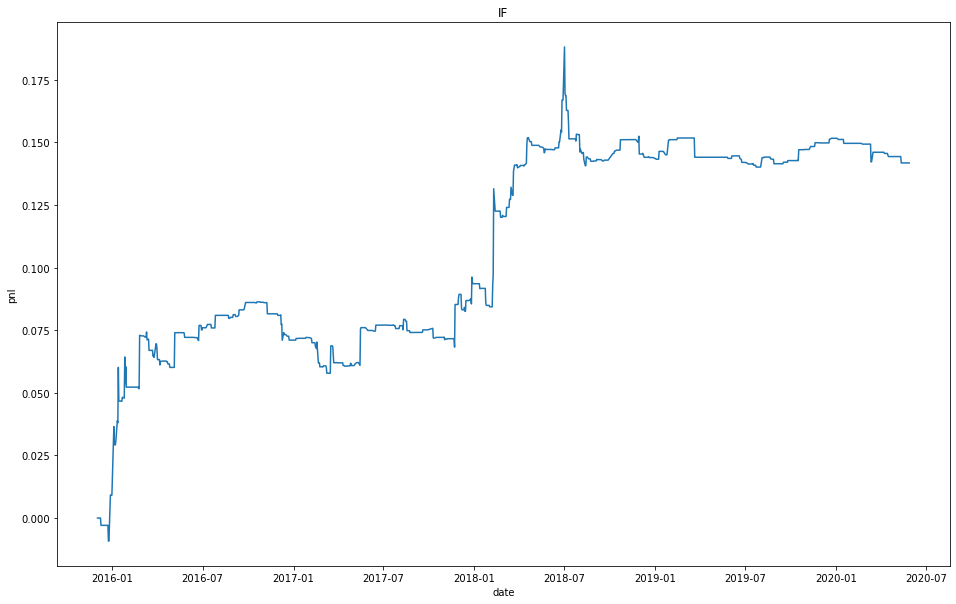

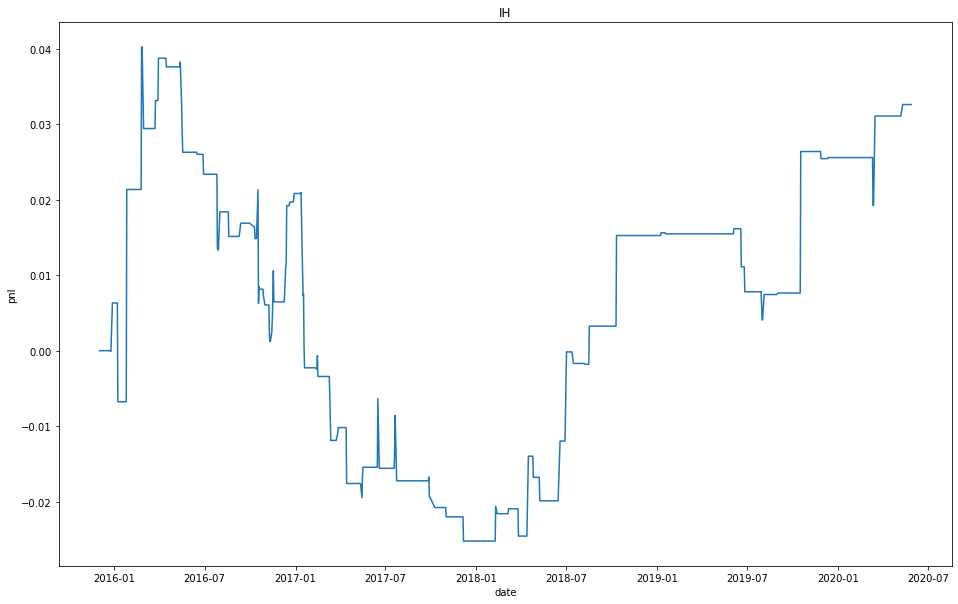

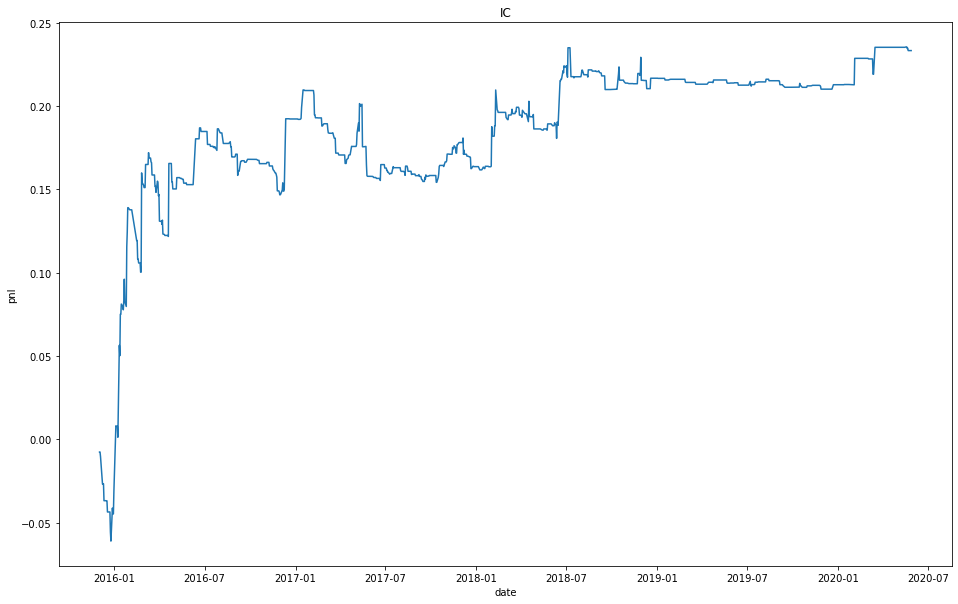

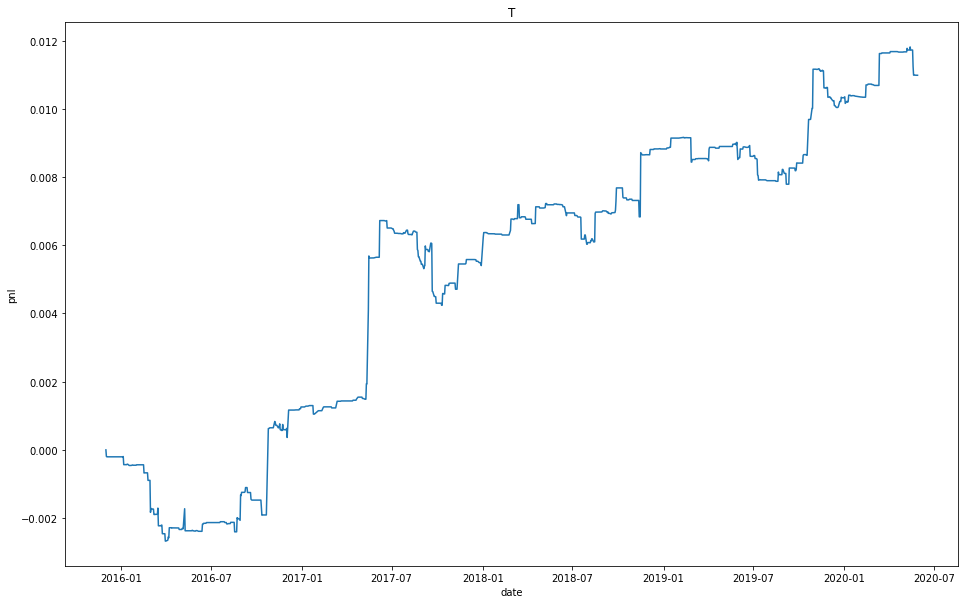

In [123]:
all_trade_stat = load(HEAD_PATH+"/"+"finance_trade_stat_total_trade_imb_4096.pkl")
all_pnl = np.zeros([n_days, len(product_list)])
i = 0
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = all_trade_stat[product]
    good_strat = trade_stat["final.result"]["avg.pnl"]>2*spread
    if sum(good_strat)==0:
        continue;
    good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    all_pnl[:,i] = good_pnl
    i = i+1
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates, good_pnl.cumsum());

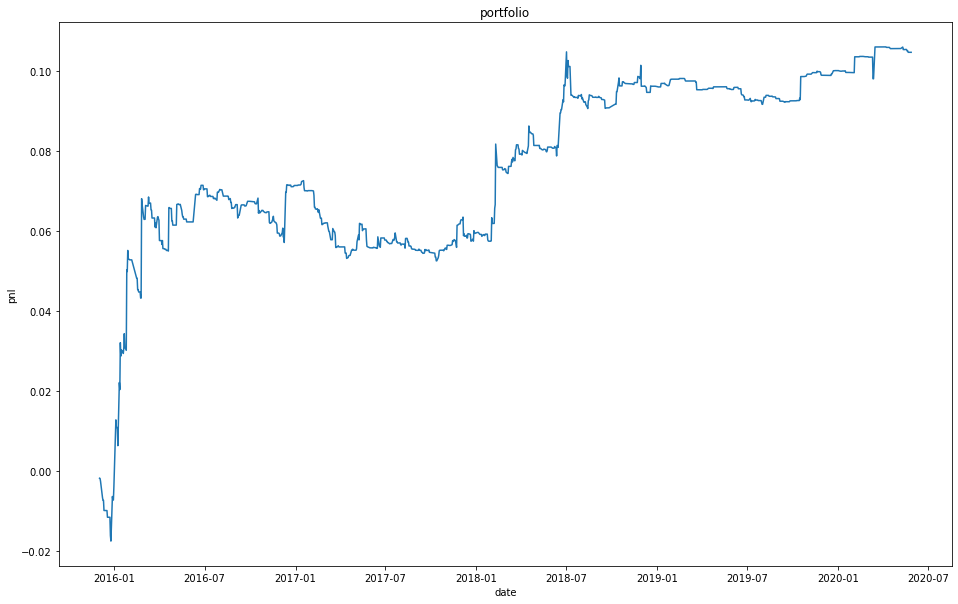

In [124]:
all_portfolio = np.array(np.mean(all_pnl[:,:i], axis=1))
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());

- get training samples

In [75]:
train_sample = np.array(all_dates)<"2018"

- now let's see the in-sample and out-of-sample performance


- the previous result used the whole data set 
- so it may be more optimistic than reality
- now we split the data into training sample and test sample


- at first let's remain 2018 as out-of-sample

- number of training samples

In [76]:
sum(train_sample)
## 510

510

In [77]:
test_sample = np.array(all_dates)>"2018"
sum(test_sample)
## 582

582

In [78]:
%%time
signal_name = "trade.imb.4096"
train_trade_stat = dict([])
open_list = np.arange(0.03, 0.05, 0.001)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
index_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
open_list = np.arange(0.03, 0.07, 0.002)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
treasury_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    if product in ["IF","IH","IC"]:
        thre_mat = index_thre_mat
    else:
        thre_mat = treasury_thre_mat
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                  atr_filter=20)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[train_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(train_sample))
    train_trade_stat[product] = trade_stat
# Wall time: 11min 18s


Wall time: 11min 18s


In [79]:
save(train_trade_stat, HEAD_PATH+"/finance_train_trade_stat.pkl")

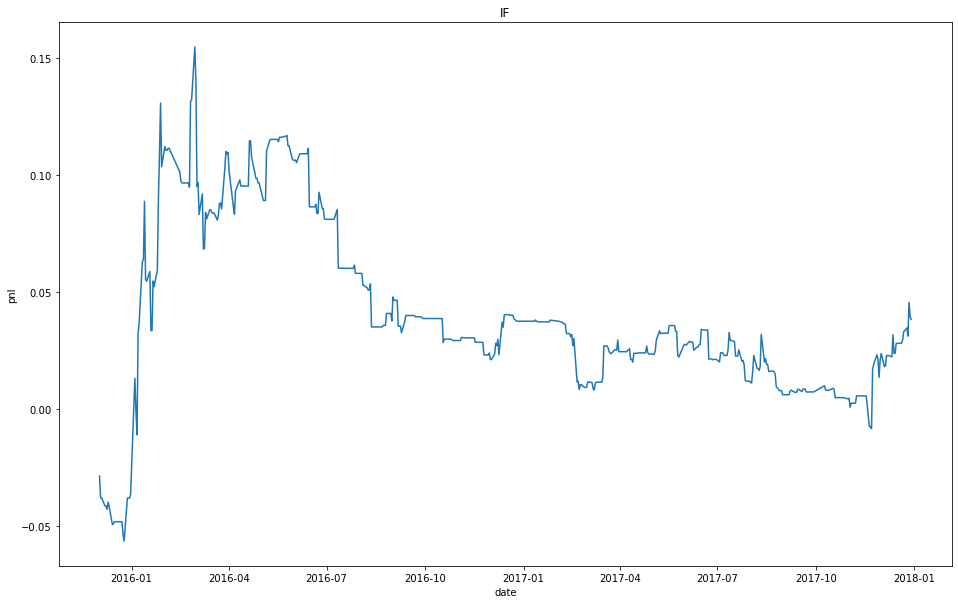

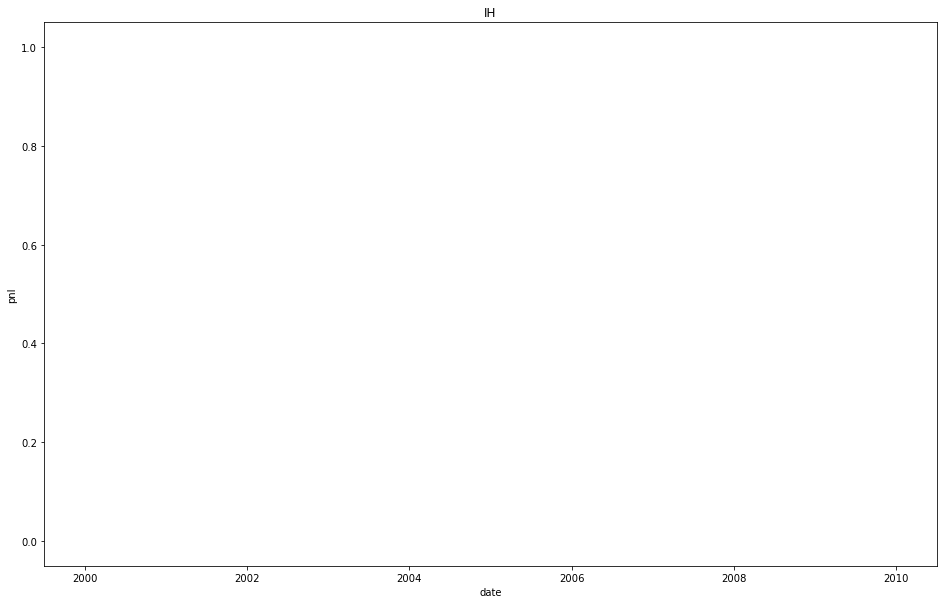

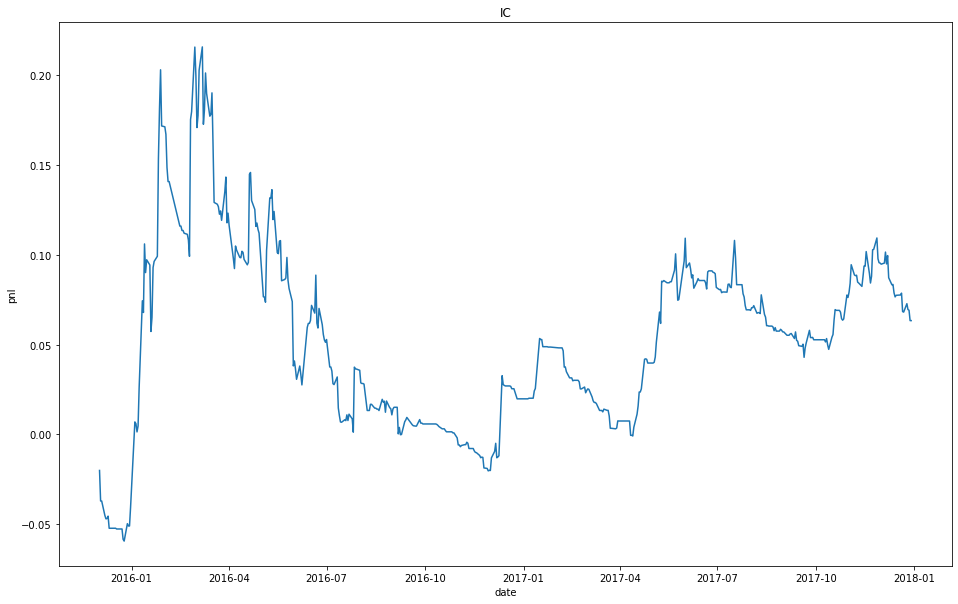

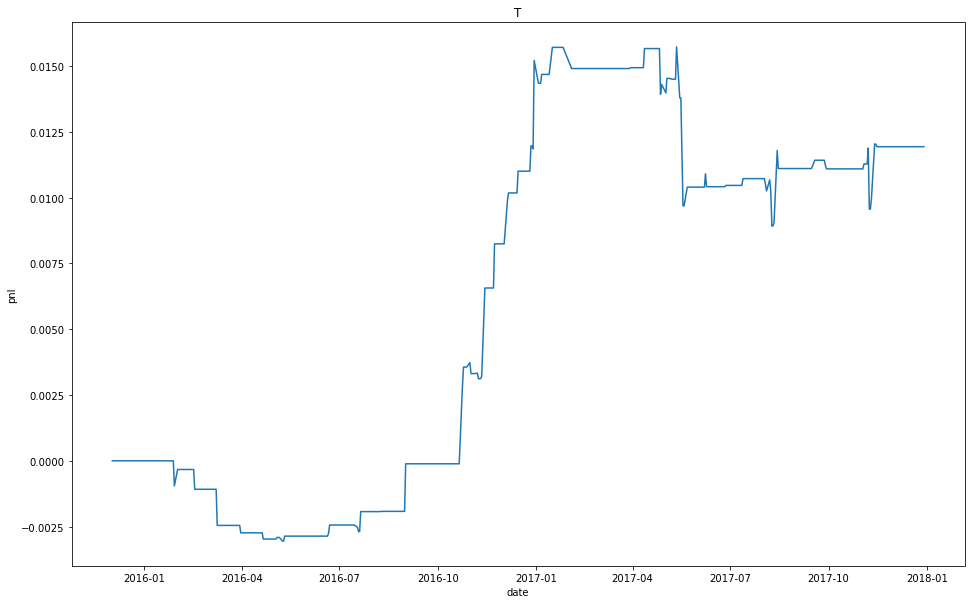

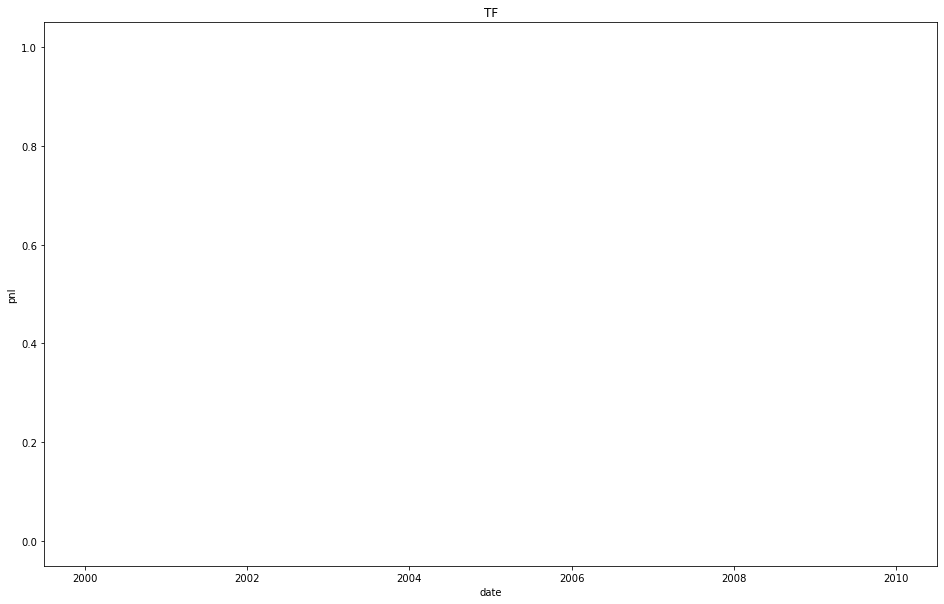

In [96]:
i = 0
train_trade_stat = load(HEAD_PATH+"/finance_train_trade_stat.pkl")
for product in product_list:
    spread = product_info[product]["spread"]
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.pnl"]>2*spread) & (trade_stat["final.result"]["num"]>20)
    good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    i = i+1
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates[train_sample], good_pnl.cumsum());


In [81]:
%%time
signal_name = "trade.imb.4096"
test_trade_stat = dict([])
open_list = np.arange(0.03, 0.05, 0.001)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
index_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
open_list = np.arange(0.03, 0.07, 0.002)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
treasury_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    if product in ["IF","IH","IC"]:
        thre_mat = index_thre_mat
    else:
        thre_mat = treasury_thre_mat
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[test_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(test_sample))
    test_trade_stat[product] = trade_stat
# Wall time: 23min 44s

Wall time: 23min 44s


In [82]:
save(test_trade_stat, HEAD_PATH+"/finance_test_trade_stat.pkl")

- now we get the out-of-sample test result

IF train sharpe  0.16809187215934024 test sharpe  0.2656861696911167
IC train sharpe  0.18812265354198707 test sharpe  -0.08959521239774536
T train sharpe  0.8863150954729068 test sharpe  -0.01020954152664748


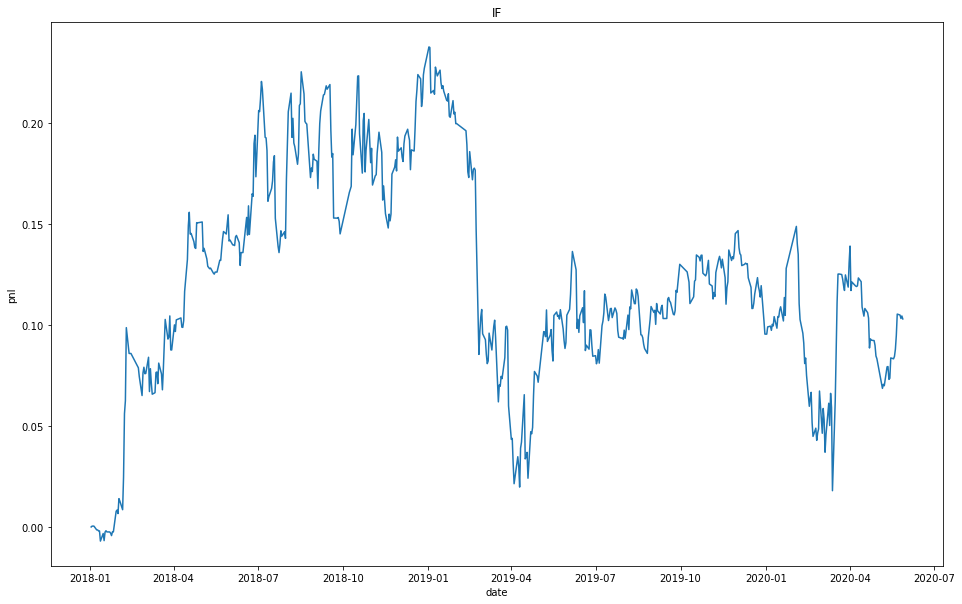

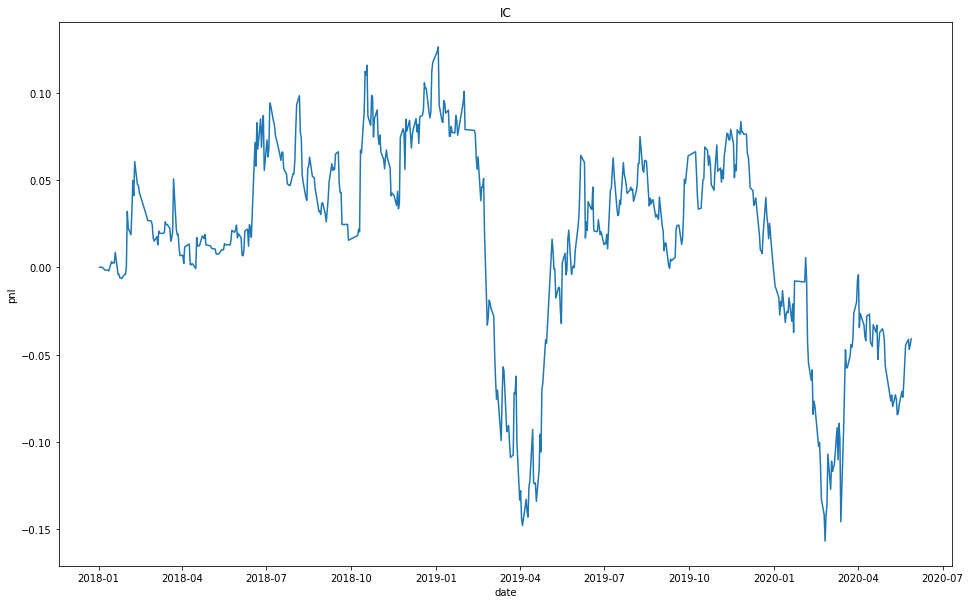

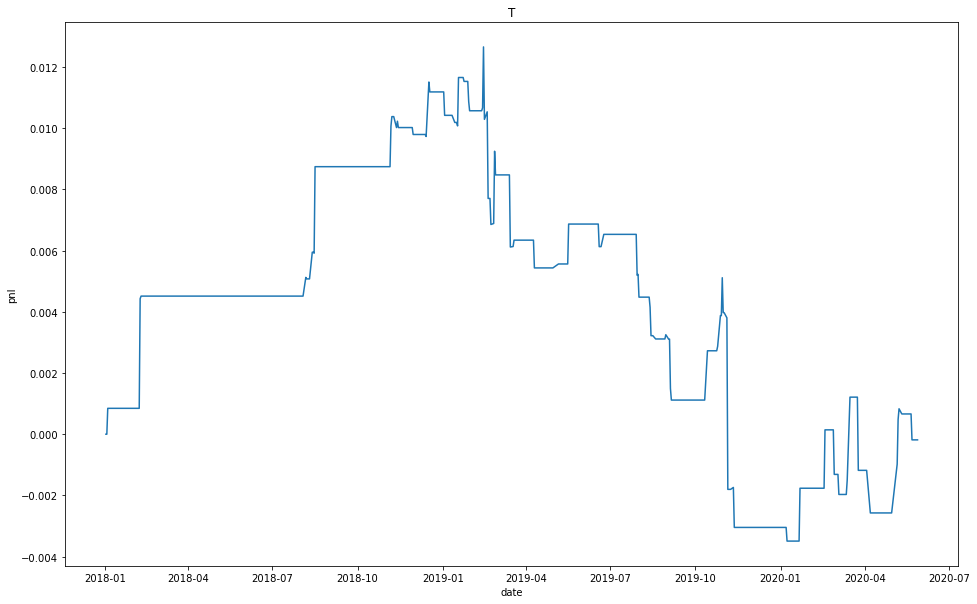

In [133]:
i = 0
train_trade_stat = load(HEAD_PATH+"/finance_train_trade_stat.pkl")
test_trade_stat = load(HEAD_PATH+"/finance_test_trade_stat.pkl")
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
for product in ["IF","IC","T"]:
    spread = product_info[product]["spread"]
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.pnl"]>2*spread) & (trade_stat["final.result"]["num"]>20)
    train_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    trade_stat = test_trade_stat[product]
    test_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates[test_sample], test_pnl.cumsum());
    
# IF train sharpe  0.16809187215934024 test sharpe  0.2656861696911167
# IH train sharpe  nan test sharpe  nan
# IC train sharpe  0.18812265354198707 test sharpe  -0.08959521239774536
# T train sharpe  0.8863150954729068 test sharpe  -0.01020954152664748
# TF train sharpe  nan test sharpe  nan




- now calculate the result of test samples

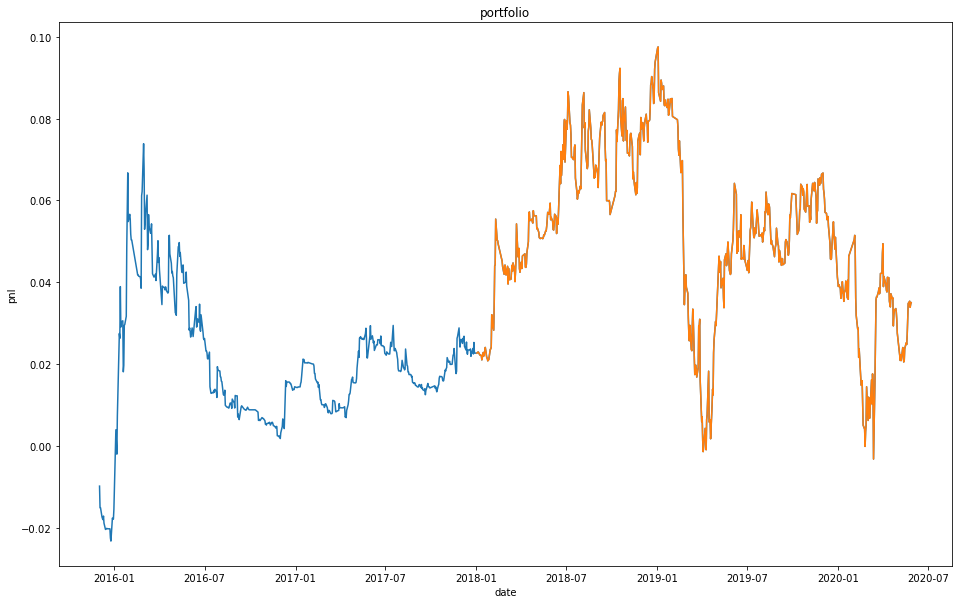

In [134]:
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
all_portfolio
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
    

In [135]:
print(sharpe(train_portfolio), sharpe(test_portfolio))
## 0.22043329598542766 0.07722591590380394


0.22043329598542766 0.07722591590380394


In [86]:
%%time
signal_name = "total.trade.imb.4096"
train_trade_stat = dict([])
open_list = np.arange(0.11, 0.15, 0.002)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
index_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
open_list = np.arange(0.1, 0.2, 0.005)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
treasury_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    if product in ["IF","IH","IC"]:
        thre_mat = index_thre_mat
    else:
        thre_mat = treasury_thre_mat
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, 
                                  atr_filter=20)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[train_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(train_sample))
    train_trade_stat[product] = trade_stat
# Wall time: 11min 18s


Wall time: 6min 23s


In [87]:
save(train_trade_stat, HEAD_PATH+"/finance_train_total_trade_stat.pkl")

In [88]:
%%time
signal_name = "total.trade.imb.4096"
test_trade_stat = dict([])
open_list = np.arange(0.11, 0.15, 0.002)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
index_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
open_list = np.arange(0.1, 0.2, 0.005)
thre_list = []
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
    thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
treasury_thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
for product in product_list:
    spread = product_info[product]["spread"]
    tranct = product_info[product]["tranct"]
    tranct_ratio = product_info[product]["tranct.ratio"]
    if product in ["IF","IH","IC"]:
        thre_mat = index_thre_mat
    else:
        thre_mat = treasury_thre_mat
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_signal_pnl, product=product, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=1, tranct=tranct, max_spread=spread*1.1, tranct_ratio=tranct_ratio, atr_filter=20)
        result = compute([delayed(f_par)(file) for file in np.array(all_dates)[test_sample]])[0]
    trade_stat = get_hft_summary(result, thre_mat, sum(test_sample))
    test_trade_stat[product] = trade_stat
# Wall time: 5min 29s

Wall time: 5min 29s


In [89]:
save(test_trade_stat, HEAD_PATH+"/finance_test_total_trade_stat.pkl")

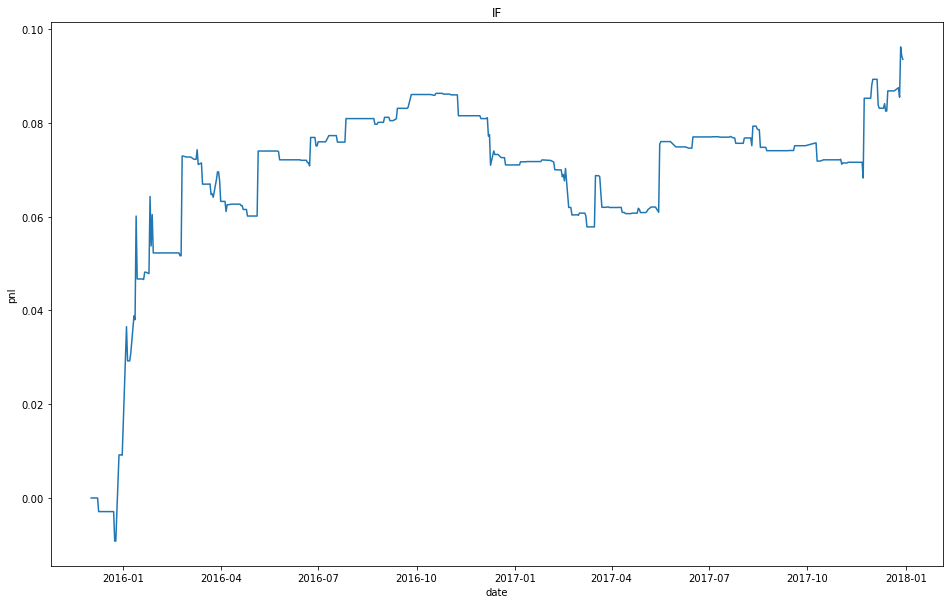

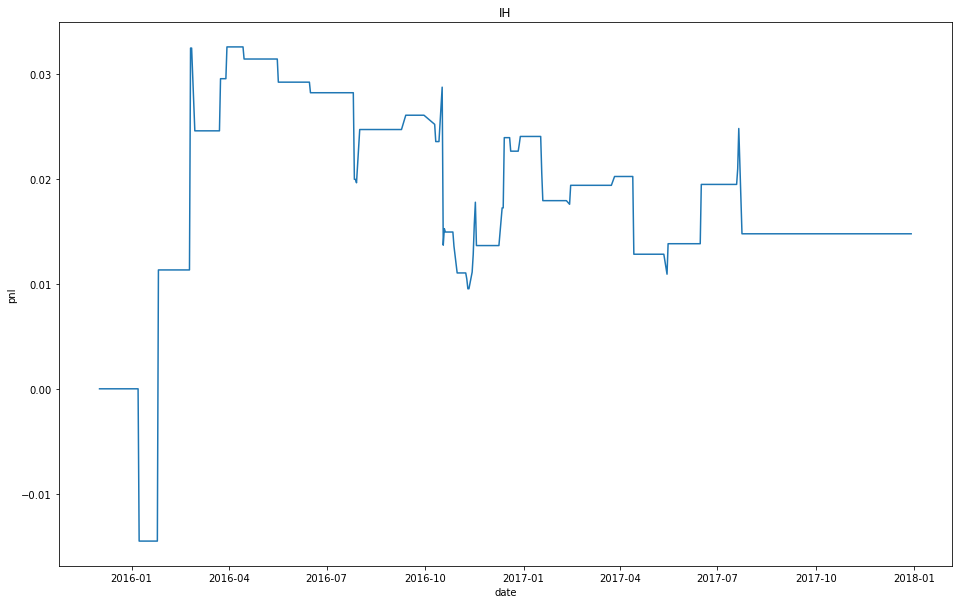

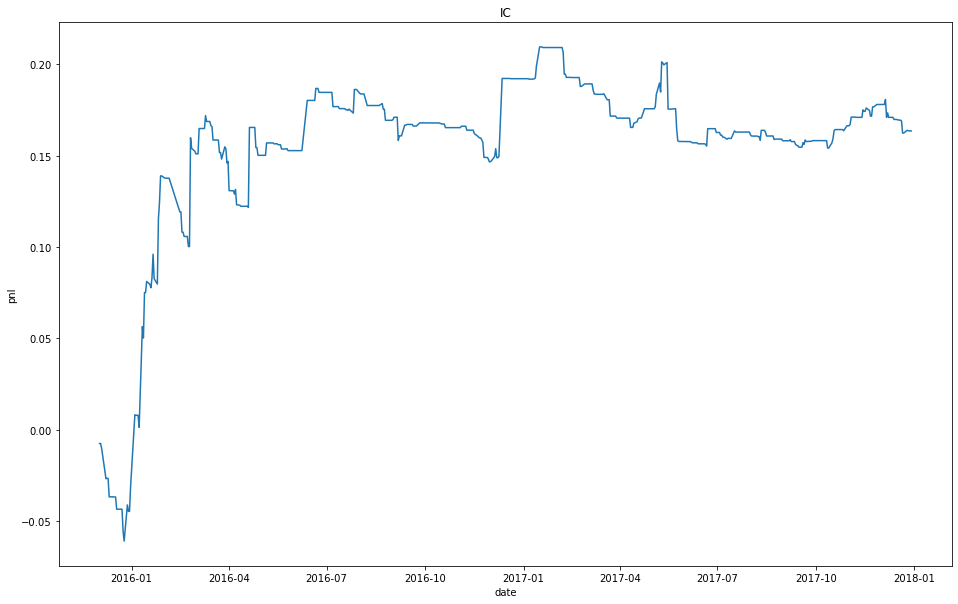

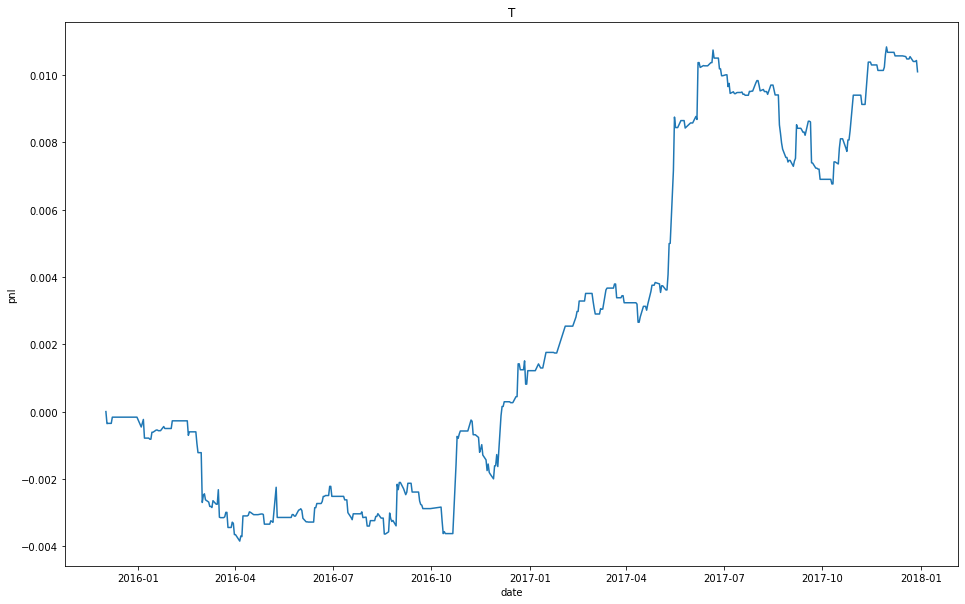

In [127]:
i = 0
train_trade_stat = load(HEAD_PATH+"/finance_train_total_trade_stat.pkl")
for product in product_list[0:4]:
    spread = product_info[product]["spread"]
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.pnl"]>2*spread) & (trade_stat["final.result"]["num"]>20)
    good_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    i = i+1
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates[train_sample], good_pnl.cumsum());

IF train sharpe  0.9957463645429173 test sharpe  0.5641598420735905
IH train sharpe  0.22399745947402736 test sharpe  0.3104919710521811
IC train sharpe  0.7920227054473593 test sharpe  0.6869405852882186
T train sharpe  1.0669181328019894 test sharpe  0.4890239041448373


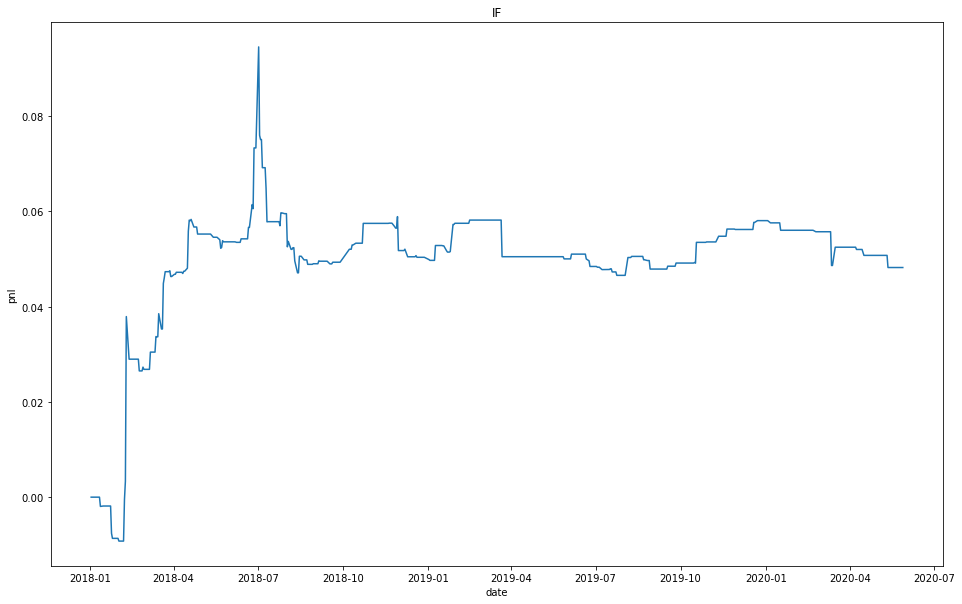

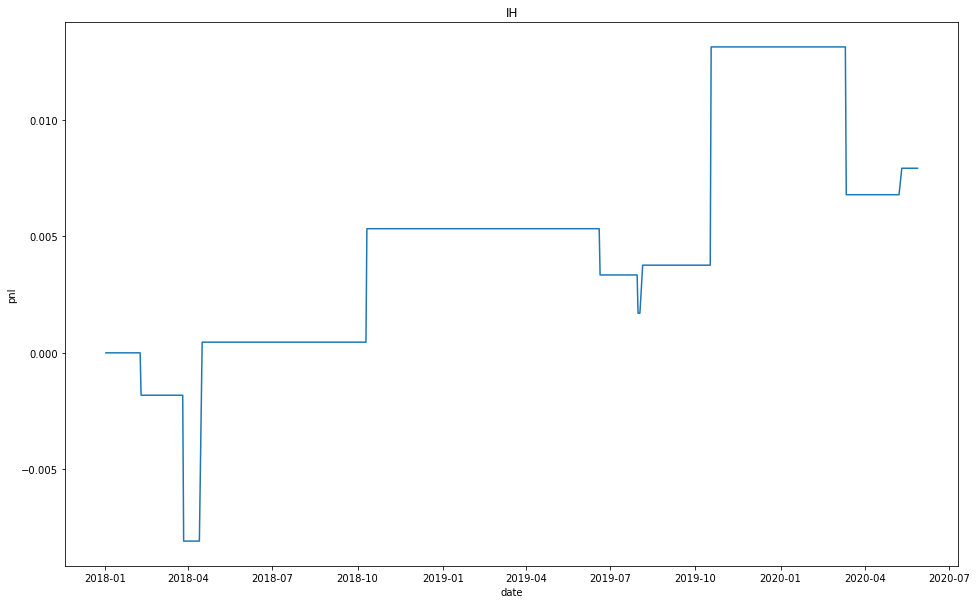

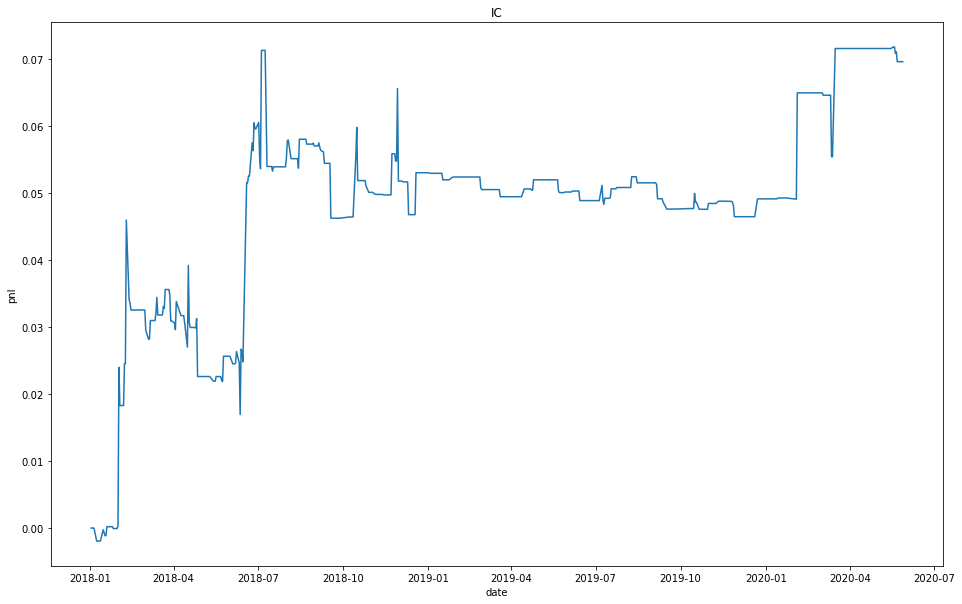

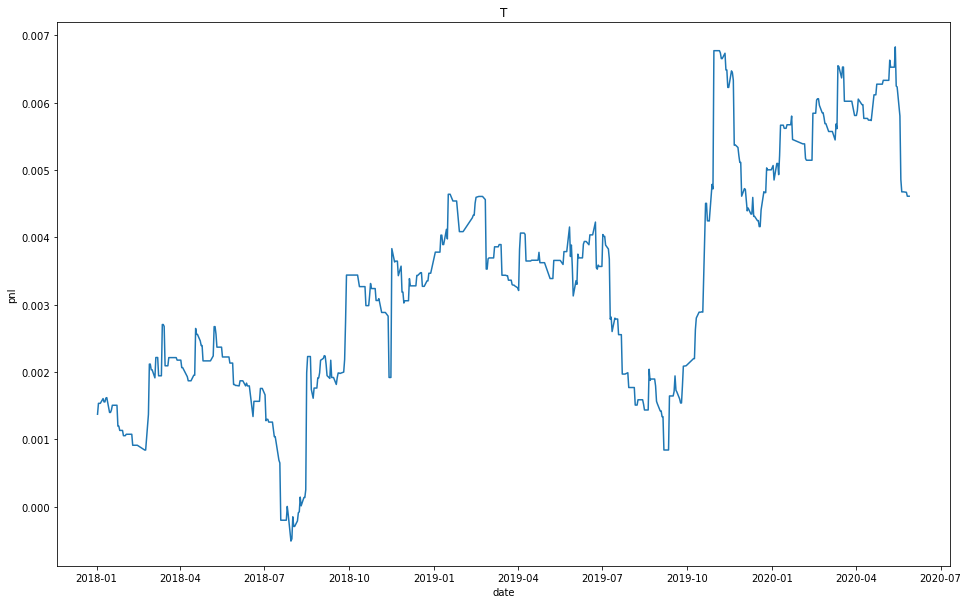

In [128]:
i = 0
test_all_pnl = np.zeros([sum(test_sample), len(product_list)])
train_all_pnl = np.zeros([sum(train_sample), len(product_list)])
test_trade_stat = load(HEAD_PATH+"/finance_test_total_trade_stat.pkl")
for product in product_list[0:4]:
    spread = product_info[product]["spread"]
    trade_stat = train_trade_stat[product]
    good_strat = (trade_stat["final.result"]["avg.pnl"]>2*spread) & (trade_stat["final.result"]["num"]>20)
    train_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    trade_stat = test_trade_stat[product]
    test_pnl = trade_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
    print(product, "train sharpe ", sharpe(train_pnl), "test sharpe ", sharpe(test_pnl))
    test_all_pnl[:,i] = test_pnl
    train_all_pnl[:,i] = train_pnl
    i = i+1
    plt.figure(i, figsize=(16, 10));
    plt.title("");
    plt.xlabel("date");
    plt.ylabel("pnl");
    plt.title(product);
    plt.plot(format_dates[test_sample], test_pnl.cumsum());
    

train sharpe  0.9534674898751362 test sharpe  0.815394962006416


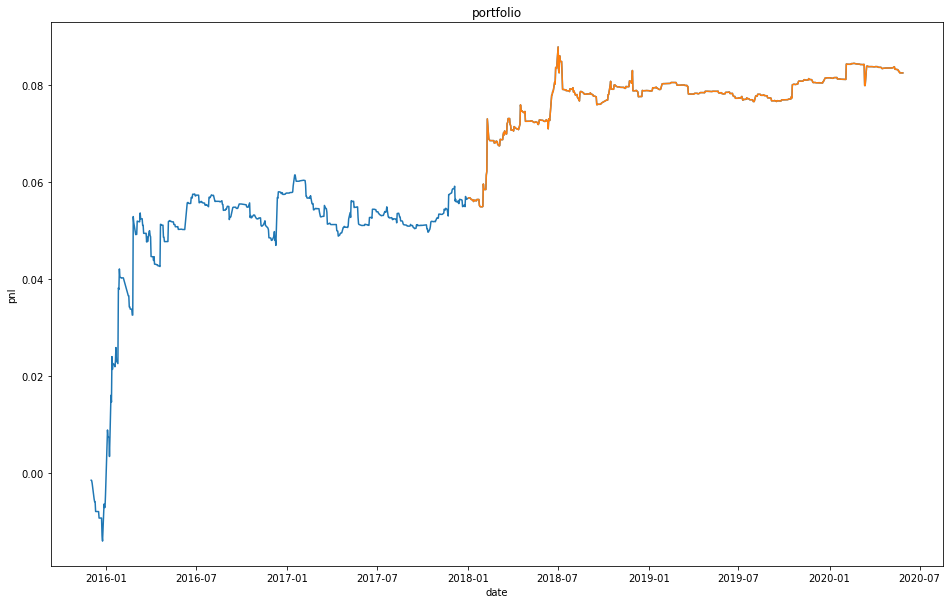

In [130]:
train_portfolio = np.array(np.mean(train_all_pnl, axis=1))
test_portfolio = np.array(np.mean(test_all_pnl, axis=1))
all_portfolio = np.append(train_portfolio, test_portfolio)
all_portfolio
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title("portfolio");
plt.plot(format_dates, all_portfolio.cumsum());
plt.plot(format_dates[test_sample], all_portfolio.cumsum()[test_sample])
print("train sharpe ", sharpe(train_portfolio), "test sharpe ", sharpe(test_portfolio))

## train sharpe  0.9534674898751362 test sharpe  0.815394962006416
